In [17]:
import calour as ca
import calour_utils as cu

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import numpy as np
import matplotlib as mpl
import pandas as pd
import scipy as sp;


In [19]:
pwd

'/Users/amnon/git/paper-daycare'

In [20]:
ca.set_log_level(11)

In [21]:
%matplotlib inline

In [22]:
db=ca.database._get_database_class('dbbact')

# Load the data

In [23]:
gan = ca.read_amplicon('data/gan-normalized.biom', 'data/gan-normalized_sample.txt', feature_metadata_file='data/gan-normalized-taxonomy.tsv', min_reads=1000, normalize=10000)

2020-08-24 15:59:03 INFO loaded 268 samples, 928 features
2020-08-24 15:59:03 WARNING Do you forget to normalize your data? It is required before running this function
2020-08-24 15:59:03 INFO After filtering, 268 remain.


### What we have

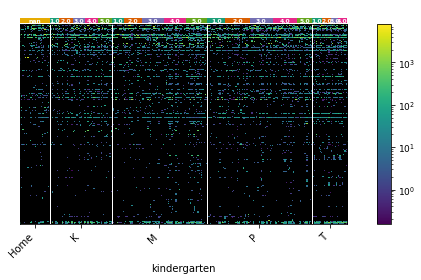

In [24]:
gan.plot(sample_field='kindergarten',barx_fields=['Time'])

# mean age at each kingergarten/timepoint

In [25]:
for cgan in gan.sample_metadata['kindergarten'].unique():
    tt=gan.filter_samples('kindergarten',cgan)
    for ctime in tt.sample_metadata['Time'].unique():
        print('gan %s' % cgan)
        print('time %s' % ctime)
        ttt=tt.filter_samples('Time',ctime)
        print('mean age %f' % np.mean(ttt.sample_metadata['age_months']))

gan Home
time nan
mean age 14.386301
gan K
time 1.0
mean age 9.336986
gan K
time 2.0
mean age 11.459029
gan K
time 3.0
mean age 14.219178
gan K
time 4.0
mean age 16.324782
gan K
time 5.0
mean age 19.600498
gan M
time 1.0
mean age 9.106849
gan M
time 2.0
mean age 11.029041
gan M
time 3.0
mean age 12.326941
gan M
time 4.0
mean age 14.681279
gan M
time 5.0
mean age 17.674134
gan P
time 1.0
mean age 13.996712
gan P
time 2.0
mean age 14.207671
gan P
time 3.0
mean age 16.614852
gan P
time 4.0
mean age 19.223014
gan P
time 5.0
mean age 19.591781
gan T
time 1.0
mean age 25.047945
gan T
time 2.0
mean age 25.409589
gan T
time 3.0
mean age 26.426301
gan T
time 4.0
mean age 30.024658


### We will use time 3 at kindergartens K,M,P to compare to home-schooling

In [26]:
# keep only timepoint 3 and Home
tt=gan.filter_samples('Time',['1','2','4','5'],negate=True)
tt=tt.filter_samples('kindergarten',['K','M','P','Home'])
tt1=tt.filter_samples('kindergarten','Home')
tt2=tt.filter_samples('kindergarten','Home',negate=True)
print('Home mean age %f (median %f)' % (np.mean(tt1.sample_metadata.age_months),np.median(tt1.sample_metadata.age_months)))
print('Gan mean age %f (median %f)' % (np.mean(tt2.sample_metadata.age_months),np.median(tt2.sample_metadata.age_months)))

Home mean age 14.386301 (median 12.361644)
Gan mean age 14.462955 (median 14.301370)


### Get the differentially abundant bacteria

In [27]:
gandiff=tt.diff_abundance('kindergarten','Home',alpha=0.25,random_seed=2020)

2020-08-24 15:59:10 INFO After filtering, 700 remain.
2020-08-24 15:59:10 INFO 24 samples with value 1 (['Home'])
2020-08-24 15:59:10 INFO number of higher in Home: 15. number of higher in NOT Home : 26. total 41


In [28]:
gandiff=gandiff.filter_by_taxonomy('Chloroplast',field='Taxon',negate=True)
gandiff

2020-08-24 15:59:11 INFO 40 features remain.


AmpliconExperiment with 71 samples, 40 features

### Plot the differentially abundant bacteria

In [13]:
gandiff=gandiff.sort_samples('age_months')

In [29]:
rr=gandiff.normalize(100)

In [30]:
cu.splot(rr,'kindergarten')

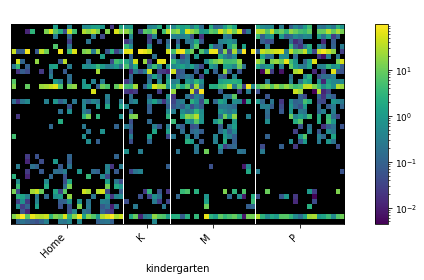

In [31]:
rr=rr.sort_samples('kindergarten')
f=rr.plot(sample_field='kindergarten')

In [32]:
f.save_figure('figures/heatmap-diff-gan-home-t3.pdf')

### Save the table of differentially abundant bacteria

In [33]:
rr.save('figures/table-diff-abund')

2020-08-24 15:59:39 INFO Metadata field taxonomy not found. Saving biom table without metadata


## dbBact term enrichment for the bacteria

2020-08-24 15:59:42 INFO Getting dbBact annotations for 40 sequences, please wait...
2020-08-24 15:59:47 INFO got 1760 annotations
2020-08-24 15:59:47 INFO Got 7016 annotation-sequence pairs
2020-08-24 15:59:47 INFO Added annotation data to experiment. Total 1760 annotations, 40 terms


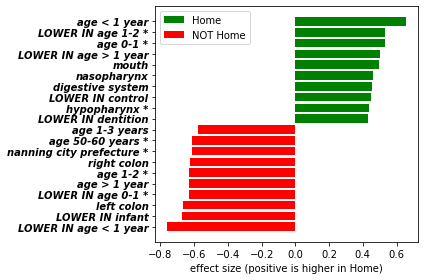

In [34]:
f=rr.plot_diff_abundance_enrichment()

In [35]:
f[0].figure.savefig('figures/fig-terms-home-enrichment-dbbact.pdf')

# look at experiments showing the age<1 enrichment

In [36]:
import matplotlib_venn
def plot_venn_group(ganexp, gandir, otherexp, otherdir, show_labels=False):
    odir_features=otherexp.feature_metadata[otherexp.feature_metadata._calour_direction == otherdir].index.values
    gandir1 = ganexp.filter_by_metadata('_calour_direction',[gandir],axis='f')
    size1=len(set(gandir1.feature_metadata.index.values).intersection(odir_features))
    gandir2 = ganexp.filter_by_metadata('_calour_direction',[gandir],negate=True,axis='f')
    size2=len(set(gandir2.feature_metadata.index.values).intersection(odir_features))
    f=plt.figure()
    print('big circle should be %d' % len(odir_features))
    if show_labels:
        v=matplotlib_venn.venn3({'101':size1, '011': size2, '001':50,
                               '010': len(gandir2.feature_metadata)-size2,
                               '100':len(gandir1.feature_metadata)-size1},
                               set_labels=['Home care', 'Day care'])
    else:
        v=matplotlib_venn.venn3({'101':size1, '011': size2, '001':50,
                               '010': len(gandir2.feature_metadata)-size2,
                               '100':len(gandir1.feature_metadata)-size1},
                               set_labels=['', ''])
        v.get_label_by_id('101').set_text('')
        v.get_label_by_id('100').set_text('')
        aa=v.get_label_by_id('011')
        if aa is not None:
            aa.set_text('')
        v.get_label_by_id('001').set_text('')
        v.get_label_by_id('010').set_text('')
    plt.title('ASVs higher in %s' % otherdir)
    return f

## Changes in the intestinal microbiota following the administration of azithromycin in a randomised placebo-controlled trial among infants in south India
expid: , 339, located in: human-baby-azithromycin

In [37]:
ages=ca.read_amplicon('/Users/amnon/Projects/human-baby-azithromycin/all.biom',
                      '/Users/amnon/Projects/human-baby-azithromycin/map.txt',
                      normalize=10000, min_reads=1000)

2020-08-24 15:59:48 INFO loaded 280 samples, 996 features
2020-08-24 15:59:48 WARNING Do you forget to normalize your data? It is required before running this function
2020-08-24 15:59:48 INFO After filtering, 280 remain.


In [38]:
ages=ages.filter_samples('non_intervention_antibiotics_days_0_to_14','yes',negate=True)
ages=ages.filter_samples('non_intervention_antibiotics_pre_enrolment','yes',negate=True)
ages=ages.filter_samples('study_day','14',negate=True)
ages.sample_metadata['group']='adult'
ages.sample_metadata.loc[ages.sample_metadata['study_day']==0,'group']='infant'


age 0 is baby, age Nan is adult

In [39]:
dd2=ages.diff_abundance('group','adult','infant',random_seed=2020)

2020-08-24 15:59:52 INFO 124 samples with both values
2020-08-24 15:59:52 INFO After filtering, 902 remain.
2020-08-24 15:59:52 INFO 40 samples with value 1 (['adult'])
2020-08-24 15:59:52 INFO number of higher in adult: 406. number of higher in infant : 55. total 461


In [40]:
cu.splot(dd2,'group')

big circle should be 406


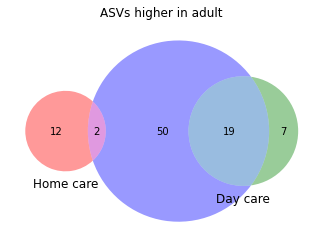

In [41]:
f=plot_venn_group(gandiff,'Home',dd2,'adult',show_labels=True)

big circle should be 406


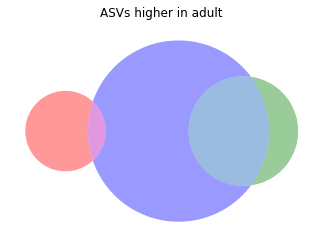

In [42]:
f=plot_venn_group(gandiff,'Home',dd2,'adult')

In [43]:
f.savefig('figures/venn-india-adult.pdf')

big circle should be 55


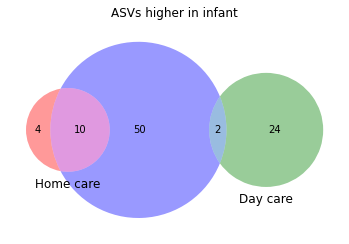

In [44]:
f=plot_venn_group(gandiff,'Home',dd2,'infant',show_labels=True)

big circle should be 55


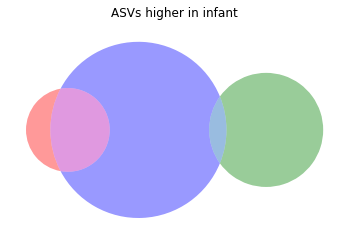

In [45]:
f=plot_venn_group(gandiff,'Home',dd2,'infant')

In [46]:
f.savefig('figures/venn-india-infant.pdf')

# The Dynamics of the Human Infant Gut Microbiome in Development and in Progression toward Type 1 Diabetes
expid: 240, located in: human-diabimmune

In [47]:
ca.set_log_level('ERROR')
daib=ca.read_amplicon('/Users/amnon/Projects/human-diabimmune/all.biom',
                      '/Users/amnon/Projects/human-diabimmune/metadata.txt',
                      normalize=10000, min_reads=1000)
ca.set_log_level('INFO')

In [48]:
daib=daib.filter_samples('Case_Control','control')

In [49]:
daib=daib.filter_sum_abundance(10)

2020-08-24 16:00:03 INFO After filtering, 1495 remain.


In [50]:
daib.sample_metadata.Age_at_Collection.values.mean()

475.13592233009706

### The age distribution histogram

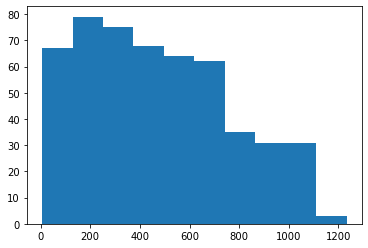

In [51]:
plt.figure()
r=plt.hist(daib.sample_metadata.Age_at_Collection.values)

In [52]:
dd2=daib.correlation('Age_at_Collection',random_seed=2020)

2020-08-24 16:00:05 INFO After filtering, 1495 remain.
2020-08-24 16:00:05 INFO Positive correlated features : 797. Negative correlated features : 103. total 900


big circle should be 797


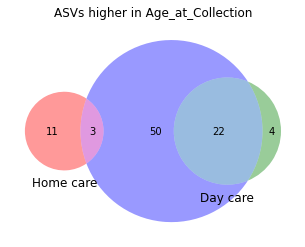

In [53]:
f=plot_venn_group(gandiff,'Home',dd2,'Age_at_Collection',show_labels=True)

big circle should be 797


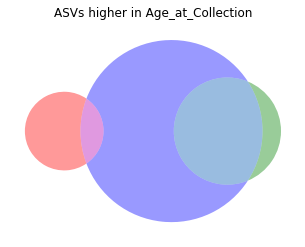

In [54]:
f=plot_venn_group(gandiff,'Home',dd2,'Age_at_Collection')

In [55]:
f.savefig('figures/venn-diabimmune-old.pdf')

big circle should be 103


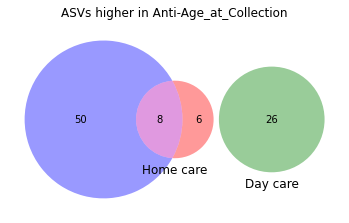

In [56]:
f=plot_venn_group(gandiff,'Home',dd2,'Anti-Age_at_Collection',show_labels=True)

big circle should be 103


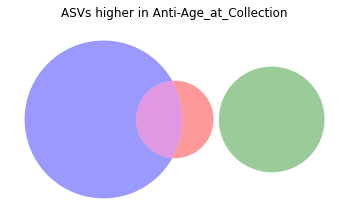

In [57]:
f=plot_venn_group(gandiff,'Home',dd2,'Anti-Age_at_Collection')

In [58]:
f.savefig('figures/venn-diabimmune-young.pdf')

# Variation in Microbiome LPS Immunogenicity Contributes to Autoimmunity in Humans
expid: 241, located in: human-three-country

In [59]:
ca.set_log_level('ERROR')
daib=ca.read_amplicon('/Users/amnon/Projects/human-three-country/all.biom',
                      '/Users/amnon/Projects/human-three-country/meta.tsv',
                      normalize=10000, min_reads=1000)
ca.set_log_level('INFO')

In [60]:
daib=daib.filter_samples('age_at_collection',None)

In [61]:
dd2=daib.correlation('age_at_collection',random_seed=2020)

2020-08-24 16:00:09 INFO After filtering, 5444 remain.
2020-08-24 16:00:14 INFO Positive correlated features : 1797. Negative correlated features : 536. total 2333


### The age distribution histogram

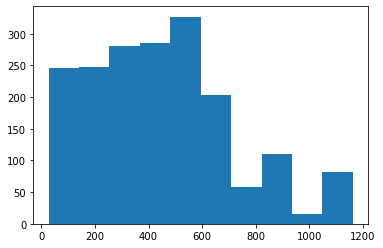

In [62]:
plt.figure()
r=plt.hist(daib.sample_metadata.age_at_collection)

big circle should be 1797


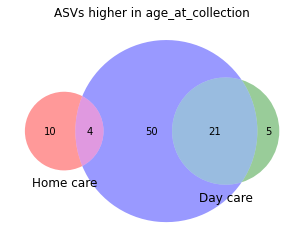

In [63]:
f=plot_venn_group(gandiff,'Home',dd2,'age_at_collection',show_labels=True)

big circle should be 1797


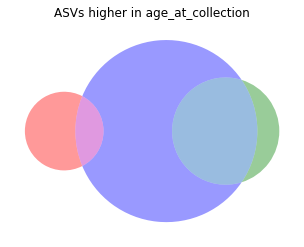

In [64]:
f=plot_venn_group(gandiff,'Home',dd2,'age_at_collection')

In [65]:
f.savefig('figures/venn-threecountries-old.pdf')

big circle should be 536


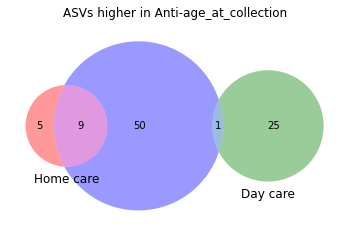

In [66]:
f=plot_venn_group(gandiff,'Home',dd2,'Anti-age_at_collection',show_labels=True)

big circle should be 536


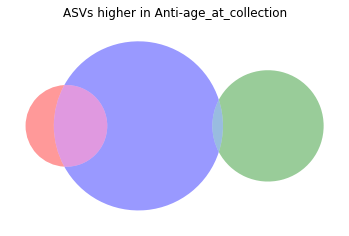

In [67]:
f=plot_venn_group(gandiff,'Home',dd2,'Anti-age_at_collection')

In [68]:
f.savefig('figures/venn-threecountries-young.pdf')